In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder
from ATARI.utils.stats import chi2_val

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 
import importlib

In [2]:
%matplotlib widget

In [3]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


spin_groups = [ (3.0,1,0) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   


E_min_max = [75, 125]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

# experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
#                          'n':  {'val':0.067166,     'unc'   :0}}
experiment_parameters = {'bw': {'val':0.1024,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/Ta181_500samples_E75_125/Ta181_500samples_E75_125_1.hdf5'
dataset_range = (0, 10)
samples_not_generated = generate(Ta_pair, exp, 
                                        'syndat_SLBW', 
                                        dataset_range, 
                                        case_file,
                                        fixed_resonance_ladder=None, 
                                        open_data=None,
                                        vary_Erange=None,
                                        use_hdf5=True,
                                        overwrite = False
                                                                    )

In [4]:
with h5py.File(case_file) as f:
    print(f['sample_7'].keys())

<KeysViewHDF5 ['CovT', 'exp_cov', 'exp_pw', 'par_fit', 'par_fit_pv_0p03', 'par_fit_pv_0p07', 'par_par_est_7_pv_0001', 'par_par_est_7_pv_0001668', 'par_par_est_7_pv_0002782', 'par_par_est_7_pv_0004641', 'par_par_est_7_pv_0007742', 'par_par_est_7_pv_001', 'par_par_est_7_pv_0012915', 'par_par_est_7_pv_0021544', 'par_par_est_7_pv_0035938', 'par_par_est_7_pv_005', 'par_par_est_7_pv_0059948', 'par_par_est_7_pv_01', 'par_par_est_7_pv_019346938775510206', 'par_par_est_7_pv_025', 'par_par_est_7_pv_03769387755102041', 'par_par_est_7_pv_05', 'par_par_est_7_pv_056040816326530615', 'par_par_est_7_pv_07438775510204082', 'par_par_est_7_pv_075', 'par_par_est_7_pv_09273469387755102', 'par_par_est_7_pv_1', 'par_par_est_7_pv_11108163265306123', 'par_par_est_7_pv_12942857142857145', 'par_par_est_7_pv_14777551020408164', 'par_par_est_7_pv_16612244897959183', 'par_par_est_7_pv_18446938775510205', 'par_par_est_7_pv_2', 'par_par_est_7_pv_20281632653061227', 'par_par_est_7_pv_22116326530612246', 'par_par_est_7

In [7]:
from ATARI.utils.misc import fine_egrid 


from ATARI.utils.io.experimental_parameters import BuildExperimentalParameters_fromDIRECT, DirectExperimentalParameters
from ATARI.utils.io.theoretical_parameters import BuildTheoreticalParameters_fromHDF5, BuildTheoreticalParameters_fromATARI, DirectTheoreticalParameters
from ATARI.utils.io.pointwise_container import BuildPointwiseContainer_fromHDF5, BuildPointwiseContainer_fromATARI, DirectPointwiseContainer
from ATARI.utils.io.data_container import BuildDataContainer_fromBUILDERS, BuildDataContainer_fromOBJECTS, DirectDataContainer


# read hdf
case_file = "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/Ta181_500samples_E75_125/Ta181_500samples_E75_125_1.hdf5"
casenum = 128
 

### Build from hdf5
builder_exppar = BuildExperimentalParameters_fromDIRECT(0.067166, 0, 1e-2)
exppar = builder_exppar.construct()

builder_theopar = BuildTheoreticalParameters_fromHDF5('true', case_file, casenum, Ta_pair)
truepar = builder_theopar.construct()

builder_pw = BuildPointwiseContainer_fromHDF5(case_file, casenum)
pw = builder_pw.construct_lite_w_CovT()

builder_dc = BuildDataContainer_fromOBJECTS( pw, exppar, [truepar])
dc = builder_dc.construct()

dc.pw.fill_exp_xs(dc.experimental_parameters)

# with h5py.File(case_file) as f:
#     print(f['sample_114'].keys())

Model 'true' already exists in pw.exp, bypassing pointwise reconstruction


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


<ErrorbarContainer object of 3 artists>

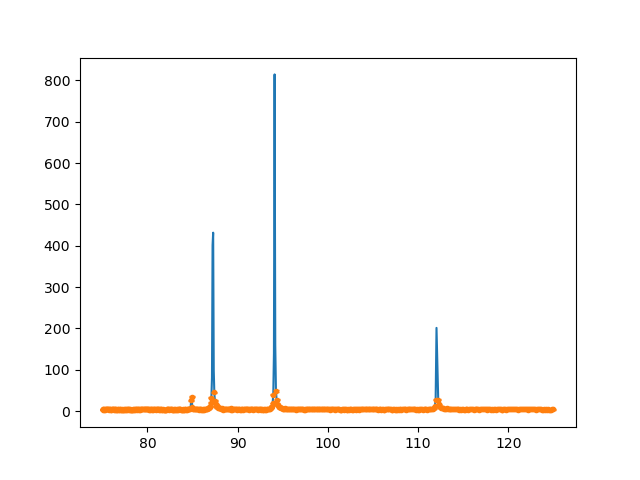

In [8]:
figure()
# plot(pw.fine.E, pw.fine.theo_xs)
plot(dc.pw.exp.E, dc.pw.exp.true_xs)

errorbar(dc.pw.exp.E, dc.pw.exp.exp_xs, yerr=dc.pw.exp.exp_xs_unc, fmt='.', capsize=2)
# plot(dc.pw.exp.E, dc.pw.exp.exp_trans, '.')
# ylim([-max_xs*.1, max_xs*1.25])


In [9]:
chi2_val(dc.pw.exp.true_xs, dc.pw.exp.exp_xs, np.diag(dc.pw.exp.exp_xs_unc**2))
chi2_val(dc.pw.exp.true_xs, dc.pw.exp.exp_xs, np.diag(np.diag(dc.pw.CovXS)))

nan

In [10]:

import classes as cls

## Approach

0. Solve initial and reduce feature bank (don't want to do this step but I am for now to speed up computation)

1. Loop and refine feature grid while chi2 improves
    - Solve quadratic program to get min($\Chi^2$) s.t. blackout resonance constraint and a large lasso constraint (99 quantile for weights * 99 quantile for # of resonances)
    - solve min(|weights|) with constraint on chi2
    - repeat with feature refinement until some threshold


3. After initial solve, begin to step up in chi2 constraint on min(|weights|) solve

5. Perform LRT between the models from 4

In [21]:
### Unit test for feature bank construction

# fb0 = prob.get_FeatureBank(dc, [575], [100e-3])
# # inp0 = prob.get_MatrixInputs(dc, fb0)
# fb0.solution_ws = np.array([50e-3])
# test_par = TheoreticalParameters(Ta_pair, pd.DataFrame({'E':575, 'Gt':100, 'Gnx':50, 'Gg':50, 'J':3.0,'chs':1,'lwave':0.0, 'J_ID':None}, index=[0]))
# test,_,_ = SLBW(dc.pw.exp.E, Ta_pair, test_par.resonance_ladder)

# figure()
# plot(dc.pw.exp.E, fb0.model-test)
# # plot(dc.pw.exp.E, test)


TypeError: can't multiply sequence by non-int of type 'float'

## Step 0, reduce initial feature bank for computational speed

In [16]:
# ### Step 0
# average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
# Elam_features, Gtot_features = fn.get_parameter_grid(dc.pw.exp.E, average_parameters, '3.0', 2e0, 3e0)
# # Gtot_features = np.append(Gtot_features, np.round(np.array(dc.theoretical_parameters['true'].resonance_ladder.Gt),1)*1e-3 )
# # Elam_features = np.append(Elam_features, np.round(np.array(dc.theoretical_parameters['true'].resonance_ladder.E),1))
# # Elam_features = np.round(np.array(theo_resladder.E),1)
# # Gtot_features = np.array(theo_resladder.Gt)*1e-3
# # Elam_features = np.array(theo_resladder.E)

# w_threshold = 1e-6
# prob = cls.ProblemHandler(w_threshold)

# fb0 = prob.get_FeatureBank(dc, Elam_features, Gtot_features)
# inp0 = prob.get_MatrixInputs(dc, fb0)

# sol_lp0 = cls.Solvers.solve_linear_program(inp0)
# print(fb0.nfeatures)
# print(np.count_nonzero(sol_lp0>0))
# Gtot_features

## Step 1, solve unconstrained problem

In [17]:
qpopt = cls.QPopt(verbose=True,
                abstol = 1e-6,
                reltol = 1e-6,
                feastol=1e-6,
                    maxiters = 200)

#### Sobes Functions

In [18]:
from scipy.stats import chi2 as chi2pdf
from scipy.stats.distributions import chi2
from cvxopt import matrix, solvers, lapack, blas, mul, div


def getD(xi,res_par_avg):    
    return res_par_avg['<D>']*2*np.sqrt(np.log(1/(1-xi))/np.pi)

def make_res_par_avg(D_avg, Gn_avg, n_dof, Gg_avg, g_dof, print):
    
    res_par_avg = {'<D>'  :D_avg,'<Gn>' :Gn_avg,'n_dof':n_dof,'<Gg>' :Gg_avg,'g_dof':g_dof}

    res_par_avg['D01']  = getD(0.01,res_par_avg)
    res_par_avg['D99']  = getD(0.99,res_par_avg)
    res_par_avg['Gn01'] = res_par_avg['<Gn>']*chi2.ppf(0.01, df=res_par_avg['n_dof'])/res_par_avg['n_dof']
    res_par_avg['Gn99'] = res_par_avg['<Gn>']*chi2.ppf(0.99, df=res_par_avg['n_dof'])/res_par_avg['n_dof']
    res_par_avg['Gg01'] = res_par_avg['<Gg>']*chi2.ppf(0.01, df=res_par_avg['g_dof'])/res_par_avg['g_dof']
    res_par_avg['Gg99'] = res_par_avg['<Gg>']*chi2.ppf(0.99, df=res_par_avg['g_dof'])/res_par_avg['g_dof']
    res_par_avg['Gt01'] = res_par_avg['Gn01'] + res_par_avg['Gg01']
    res_par_avg['Gt99'] = res_par_avg['Gn99'] + res_par_avg['Gg99']

    if print:
        print('D99  =',res_par_avg['D99'])
        print('Gn01 =',res_par_avg['Gn01'])
        print('Gn99 =',res_par_avg['Gn99'])
        print('Gg01 =',res_par_avg['Gg01'])
        print('Gg99 =',res_par_avg['Gg99'])
        print('Gt01 =',res_par_avg['Gt01'])
        print('Gt99 =',res_par_avg['Gt99'])

    return res_par_avg

def refine_feature_vectors(Er, x, thr, option, Gt, res_par_avg):            
    
    x_bin = x > thr['ub']  
    if option < 2:
        x_bin = x_bin.reshape((len(Er),len(Gt)        ))  
        x_bin = np.any(x_bin,axis=1)
    else:
        x_bin = x_bin.reshape((len(Er),len(Gt),len(Gt)))
        x_bin = np.any(x_bin,axis=(1,2))
        
    Er = Er[x_bin] 
    
    deltaE = min(np.diff(Er))/3 # divide by 3 such that neighboring resonances won't split into a repeating resonance
    Er_new = np.zeros(2*len(Er))
    
    for iEr in range(len(Er)):
        Er_new[2*iEr  ] = Er[iEr] - deltaE
        Er_new[2*iEr+1] = Er[iEr] + deltaE
        
    if option < 2:
        num_Gt = int(        len(x)/len(Er_new) ) + 1 
        num_Gn = 1
    else:
        num_Gt = int(np.sqrt(len(x)/len(Er_new))) + 1 
        num_Gn = num_Gt
                        
    Gt = np.logspace(np.log10(res_par_avg['Gt01']), np.log10(res_par_avg['Gt99']), num_Gt)    
    Gn = np.logspace(np.log10(res_par_avg['Gn01']), np.log10(res_par_avg['Gn99']), num_Gn)
            
    return Er_new, Gt, Gn

def collapse_Er(Er,x,res_par_avg):    

    x_bin = x > thr['ub']  
    if option < 2:
        x_bin = x_bin.reshape((len(Er),len(Gt)        ))
        x_bin = np.any(x_bin,axis=1)
    else:
        x_bin = x_bin.reshape((len(Er),len(Gt),len(Gt)))
        x_bin = np.any(x_bin,axis=(1,2))
        
    Er = Er[ x_bin]        
    diff_Er = np.diff(Er)
    
    Er_lb = Er - res_par_avg['D01']/2
    Er_ub = Er + res_par_avg['D01']/2    

    index = np.argwhere(diff_Er < res_par_avg['D01'])
    for iEr in np.flipud(index):       
        Er_lb = np.delete(Er_lb, iEr+1        )
        Er_ub = np.delete(Er_ub, iEr          ) 
    
    return Er_lb, Er_ub

def collapse_feature_bank(Er,Gt,Gn,thr,A,x,option,res_par_avg):    

    if option < 2:
        inc = len(Gt)        
    else:
        inc = len(Gt)*len(Gn)
    
    for iEr in range(len(Er)):
        index = slice(inc*iEr,inc*(iEr+1))
        A[:,iEr] = (A[:,index].dot(x[index])).flatten()
    A = A[:,slice(len(Er))]
        
    x_bin = x > thr['ub']  
    if option < 2:
        x_bin = x_bin.reshape((len(Er),len(Gt)        ))
        x_bin = np.any(x_bin,axis=1)
    else:
        x_bin = x_bin.reshape((len(Er),len(Gt),len(Gt)))
        x_bin = np.any(x_bin,axis=(1,2))
        
    Er = Er[  x_bin]
    A  =  A[:,x_bin]
      
    diff_Er = np.diff(Er)    
    index = np.argwhere(diff_Er < res_par_avg['D01'])
    for iEr in np.flipud(index): 
        A[:,iEr] = A[:,iEr] + A[:,iEr+1]
        A = np.delete(A, iEr+1, axis=1)  
    
    return A

def build_constraints(Er, Gt, res_par_avg, index_0T, dc:DataContainer, feature_bank:cls.FeatureBank, Gn=[1]):

    # get 0Trans constraint
    # lb, ub = fn.get_bound_arrays(nfeatures, feature_bank.w_bounds)
    C, d = fn.get_0Trans_constraint(np.array(dc.pw.exp.E), index_0T, dc.experimental_parameters.max_xs, dc.theoretical_parameters['true'].particle_pair, feature_bank.feature_pairs)
    d = d.reshape((-1,1))
    
    num_Er = len(Er)
    num_Gt = len(Gt)
    num_Gn = len(Gn)    
    num_F = num_Er*num_Gt*num_Gn

    # concatenate upper bound constraints
    C = np.concatenate((C, -np.eye(num_F),np.eye(num_F)))
    if option == 0:
        d = np.concatenate((d, np.zeros((num_F,1)),res_par_avg['Gn99']*np.ones((num_F,1))))  
    else:
        d = np.concatenate((d, np.zeros((num_F,1)),                    np.ones((num_F,1))))       
    
    # lasso constraint
    C =  np.concatenate((C,np.ones( (1,num_F))))
    d =  np.concatenate((d,np.zeros((1,1    ))))
    
    return C, d

def make_qp_input(A,data,C,d):
    P = matrix( np.transpose(A).dot(A))
    q = matrix(-np.transpose(A).dot(data))
    G = matrix(C)
    h = matrix(d)
    return P, q, G, h

def qp_solve(P,q,G,h,theta=None,x0=None):        
    
    if theta is not None:
        h[-1] = theta
    
    if x0 is not None:
        x0 = {'x':matrix(x0)}        
    
    prob = solvers.qp(P, q, G, h, initvals = x0)
    x = np.array(prob['x'])                  
    
    return x  

def     qcl1(A, b):
    """
    Returns the solution u, z of

        (primal)  minimize    || u ||_1
                  subject to  || A * u - b ||_2  <= 1

        (dual)    maximize    b^T z - ||z||_2
                  subject to  || A'*z ||_inf <= 1.

    Exploits structure, assuming A is m by n with m >= n.
    """

    m, n = A.size

    # Solve equivalent cone LP with variables x = [u; v].
    #
    #     minimize    [0; 1]' * x
    #     subject to  [ I  -I ] * x <=  [  0 ]   (componentwise)
    #                 [-I  -I ] * x <=  [  0 ]   (componentwise)
    #                 [ 0   0 ] * x <=  [  1 ]   (SOC)
    #                 [-A   0 ]         [ -b ]
    #
    #     maximize    -t + b' * w
    #     subject to  z1 - z2 = A'*w
    #                 z1 + z2 = 1
    #                 z1 >= 0,  z2 >=0,  ||w||_2 <= t.

    c = matrix(n*[0.0] + n*[1.0])
    h = matrix( 0.0, (2*n + m + 1, 1))
    h[2*n] = 1.0
    h[2*n+1:] = -b

    def G(x, y, alpha = 1.0, beta = 0.0, trans = 'N'):
        y *= beta
        if trans=='N':
            # y += alpha * G * x
            y[:n] += alpha * (x[:n] - x[n:2*n])
            y[n:2*n] += alpha * (-x[:n] - x[n:2*n])
            y[2*n+1:] -= alpha * A*x[:n]

        else:
            # y += alpha * G'*x
            y[:n] += alpha * (x[:n] - x[n:2*n] - A.T * x[-m:])
            y[n:] -= alpha * (x[:n] + x[n:2*n])


    def Fkkt(W):
        """
        Returns a function f(x, y, z) that solves

            [ 0   G'   ] [ x ] = [ bx ]
            [ G  -W'*W ] [ z ]   [ bz ].
        """

        # First factor
        #
        #     S = G' * W**-1 * W**-T * G
        #       = [0; -A]' * W3^-2 * [0; -A] + 4 * (W1**2 + W2**2)**-1
        #
        # where
        #
        #     W1 = diag(d1) with d1 = W['d'][:n] = 1 ./ W['di'][:n]
        #     W2 = diag(d2) with d2 = W['d'][n:] = 1 ./ W['di'][n:]
        #     W3 = beta * (2*v*v' - J),  W3^-1 = 1/beta * (2*J*v*v'*J - J)
        #        with beta = W['beta'][0], v = W['v'][0], J = [1, 0; 0, -I].

        # As = W3^-1 * [ 0 ; -A ] = 1/beta * ( 2*J*v * v' - I ) * [0; A]
        beta, v = W['beta'][0], W['v'][0]
        As = 2 * v * (v[1:].T * A)
        As[1:,:] *= -1.0
        As[1:,:] -= A
        As /= beta

        # S = As'*As + 4 * (W1**2 + W2**2)**-1
        S = As.T * As
        d1, d2 = W['d'][:n], W['d'][n:]
        d = 4.0 * (d1**2 + d2**2)**-1
        S[::n+1] += d
        lapack.potrf(S)

        def f(x, y, z):

            # z := - W**-T * z
            z[:n] = -div( z[:n], d1 )
            z[n:2*n] = -div( z[n:2*n], d2 )
            z[2*n:] -= 2.0*v*( v[0]*z[2*n] - blas.dot(v[1:], z[2*n+1:]) )
            z[2*n+1:] *= -1.0
            z[2*n:] /= beta

            # x := x - G' * W**-1 * z
            x[:n] -= div(z[:n], d1) - div(z[n:2*n], d2) + As.T * z[-(m+1):]
            x[n:] += div(z[:n], d1) + div(z[n:2*n], d2)

            # Solve for x[:n]:
            #
            #    S*x[:n] = x[:n] - (W1**2 - W2**2)(W1**2 + W2**2)^-1 * x[n:]

            x[:n] -= mul( div(d1**2 - d2**2, d1**2 + d2**2), x[n:])
            lapack.potrs(S, x)

            # Solve for x[n:]:
            #
            #    (d1**-2 + d2**-2) * x[n:] = x[n:] + (d1**-2 - d2**-2)*x[:n]

            x[n:] += mul( d1**-2 - d2**-2, x[:n])
            x[n:] = div( x[n:], d1**-2 + d2**-2)

            # z := z + W^-T * G*x
            z[:n] += div( x[:n] - x[n:2*n], d1)
            z[n:2*n] += div( -x[:n] - x[n:2*n], d2)
            z[2*n:] += As*x[:n]

        return f

    dims = {'l': 2*n, 'q': [m+1], 's': []}
    sol = solvers.conelp(c, G, h, dims, kktsolver = Fkkt)
    if sol['status'] == 'optimal':
        return sol['x'][:n],  sol['z'][-m:]
    else:
        return None, None

In [19]:
dc.theoretical_parameters['true'].resonance_ladder[["E", "Gnx", "Gt"]]

,E,Gnx,Gt
0,84.882858,0.248553,64.534479
1,87.255861,4.112082,68.966932
2,94.096864,4.563721,68.856976
3,112.074777,2.839020,68.251959


In [20]:
#
"""
Fix Wigner constraint for dynamic feature bank updating
KKT sparsty
"""

solvers.options['show_progress'] = False
solvers.options['abstol'] = 1e-7
solvers.options['reltol'] = 1e-6
qpopt.verbose = False
np.random.seed(0)
max_iter = int(1e2)

# option
# 0: w = Gn
# 1: w = Gn/Gt
# 2: w = binary
option = 0
if option != 0:
    raise ValueError("other weight options not implemented")

unc = 0.01
chi2_step = 0.05

res_par_avg = make_res_par_avg(D_avg = 8.79, Gn_avg = 46.4e-3, n_dof = 1, Gg_avg = 64e-3, g_dof = 1e3, print = False)

if option == 0:
    thr = {'ub':res_par_avg['Gn01'],'lb':res_par_avg['Gn01']/10}
else:
    thr = {'ub':1e-5,'lb':1e-6}
thr['chi2_tol'] = 1e-3

w_threshold = 1e-6
prob = cls.ProblemHandler(w_threshold)

### make syndat
# E = np.transpose(np.linspace(0, res_par_avg['D99']*2, num = int(5e2)))
# while True:
#     Er_true, Gn_true, Gt_true = sample_res_par(res_par_avg,max(E))
#     if len(Er_true) > 2:
#         break
# sigma = make_sigma(E,Er_true, Gn_true, Gt_true)
# data = make_data(sigma, unc)
Er_true = dc.theoretical_parameters['true'].resonance_ladder["E"].values
Gn_true = dc.theoretical_parameters['true'].resonance_ladder["Gnx"].values
Gt_true = dc.theoretical_parameters['true'].resonance_ladder["Gt"].values
E = dc.pw.exp.E
E = E[np.isfinite(dc.pw.exp.exp_cs)]
sigma = dc.pw.exp.theo_cs
data = dc.pw.exp.exp_cs.values.reshape((-1,1))

### Initial solve 
chi2_old = 0
for i in range(max_iter):
        
    if chi2_old == 0:
        # for first itteration, build a feature bank based on some grid and qunatiles
        # Er, Gt, Gn = build_feature_vectors(E, option, num_Er = int(1e2), num_Gt = int(3), res_par_avg = res_par_avg)
        Er, Gt, Gn = fn.get_parameter_grid_new(dc.pw.exp.E, res_par_avg, num_Er=int(3e2), num_Gt=int(20))
        # Gt = np.append(Gt, np.round(np.array(dc.theoretical_parameters['true'].resonance_ladder.Gt),1)*1e-3 )
        # Er = np.append(Er, np.round(np.array(dc.theoretical_parameters['true'].resonance_ladder.E),1))
    else:
        # all subsequent itterations refine the feature bank
        Er, Gt, Gn = refine_feature_vectors(Er, x, thr, option, Gt, res_par_avg)

    # build actual feature bank matrices and constraints
    # A, C, d, Er, Gt, Gn, x_true = build_feature_bank(E, res_par_avg, option, Er_true, Gt_true, Gn_true, Er, Gt, Gn)
    fb0 = prob.get_FeatureBank(dc, Er, Gt)
    data, cov, fb0.potential_scattering, fb0.feature_matrix, index_0T = fn.remove_nan_values(np.array(dc.pw.exp.exp_xs), np.array(dc.pw.CovXS), fb0.potential_scattering, fb0.feature_matrix)
    data = data.reshape((-1,1))
    data_corrected = data-fb0.potential_scattering
    # index_0T=[]
    C, d = build_constraints(Er, Gt, res_par_avg, index_0T, dc, fb0, Gn=[1])

    ### make and solve min(chi2) with quadratic program
    # P, q, G, h = make_qp_input(A,data,C,d)   # G=C, h=d    P = matrix( np.transpose(A).dot(A)), q = matrix(-np.transpose(A).dot(data))
    P, q, G, h = make_qp_input(fb0.feature_matrix, data_corrected, C, d)

    
    # inp0 = prob.get_MatrixInputs(dc, fb0)

    # print(np.linalg.norm((sigma-data)/unc)**2/len(E))
    # plot(A, x_true, data, unc, Er, Gt, Gn, Er_true, Gn_true, Gt_true, res_par_avg, thr, option)  
    if option == 0:       
        theta = len(Er_true)*res_par_avg['Gn99']
    else:
        theta = len(Er_true)
    fb0.w_bounds = (0, theta)
    
    x = qp_solve(P, q, G, h, theta, x0 = None)
    fb0.solution_ws = x
    # fb0.solution_ws = cls.Solvers.solve_quadratic_program(inp0, qpopt)
    # x = fb0.solution_ws

    # plot(A, x, data, unc, Er, Gt, Gn, Er_true, Gn_true, Gt_true, res_par_avg, thr, option)  
    chi2_new = np.linalg.norm(fb0.model-data) #((fb0.feature_matrix @ fb0.solution_ws).flatten() + fb0.potential_scattering)
    # print(np.linalg.norm(fb0.model-data))
    # chi2_new = chi2_val(fb0.model, data, dc.pw.CovXS)  #!!! Need to do something like cholesky decomp to get chi2 calculation into cvxopt qcl1 constraint!
    #                                                       Otherwise, it eliminates too many of the resonances whenever I solve it and I run out of them!
    print(chi2_new)
    figure()
    plot(fb0.model, 'b', lw=3)
    plot(data, '.k')

    ### solve min(|weights|) with constraint on chi2  - https://cvxopt.org/userguide/coneprog.html#exploiting-structure
    x1, z = qcl1(matrix(fb0.feature_matrix/chi2_new), matrix((data_corrected)/chi2_new))    
    # x1 = min_w() 

    # ### Handle failed solve
    if x1 is not None:      
        x1 = np.array(x1)                 
        # plot(fb0.feature_matrix, x1, data, unc, Er, Gt, Gn, Er_true, Gn_true, Gt_true, res_par_avg, thr, option)        
        x = x1      
    else:
        print('KKT Failed')
    
    fb0.solution_ws = x
    print(np.linalg.norm(fb0.model-data))
    # print(chi2_new)
    plot(fb0.model, 'r')

    ### evaluate new chi2, if improvement is greater than some threshold -> loop with refined feature bank
    if abs(chi2_new-chi2_old)/chi2_new < thr['chi2_tol']:
        break
    else:
        chi2_old = chi2_new


KeyboardInterrupt: 

In [ ]:
np.linalg.norm((fb0.feature_matrix.dot(x)-(data-fb0.potential_scattering)))#/unc)**2/len(E)

10.862351042705617

In [ ]:
A = fb0.feature_matrix.copy()
unc =0.1
chi2_step = 1

#### Step up in chi2 constraint until there are zeros resonances
Could also do a bisection here to ensure that we get all intger number of resonances

ValueError: x and y must have same first dimension, but have shapes (647,) and (638, 1)

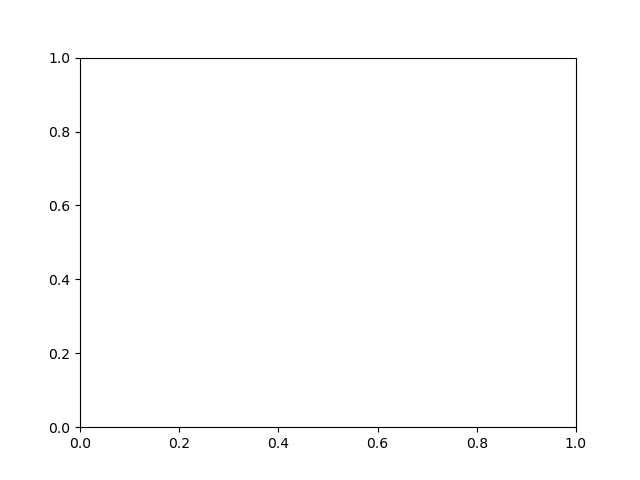

In [ ]:

### After initial solve, begin to step up in chi2 constraint on min(|weights|) solve 
steps = 0
while True:
    chi2_new += chi2_step
    # x1, z = qcl1(matrix(A/chi2_new), matrix(data/chi2_new))        
    x1, z = qcl1(matrix(A/chi2_new), matrix((data-fb0.potential_scattering)/chi2_new))    
    
    if x1 is not None:      
        x1 = np.array(x1 )         
        x = x1 
        
        Er_lb, Er_ub = collapse_Er(Er,x,res_par_avg)
        if Er_lb.size == 0:
            break

        A_new = collapse_feature_bank(Er,Gt,Gn,thr,A,x,option,res_par_avg)    

        figure()
        plot(E,data-fb0.potential_scattering,'.') 
        plot(E,A_new)
        # title(str(('num res=',len(Er_lb),'chi2=',np.linalg.norm((A.dot(x)-(data-fb0.potential_scattering))/unc)**2/len(E))))
        title(str(('num res=',len(Er_lb),'chi2=',np.linalg.norm((A.dot(x)-(data-fb0.potential_scattering))) )))
        for iEr in range(len(Er_true)):
            axvline(Er_true[iEr],color='red'  ,alpha=0.2)    
        for iEr in range(len(Er_lb)):
            fill_between(np.linspace(Er_lb[iEr],Er_ub[iEr]), 0, max(sigma), alpha=0.1, color='green')
        # show() 
              
    else:
        print('KKT Failed')

    steps += 1
    if steps == 3:
        break

In [ ]:
## Plotting combined features
# numres = 4
# # numres_other = 9
# rxn = 'xs'
# E = fine_egrid(dc.pw.exp.E, ppeV=1000)
# before, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(ires_resladder, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) )
# combined, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(ires_resladder_combined, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) )

# figure()
# # plot(dc.pw.fine.E, dc.pw.fine[f'theo_{rxn}'], 'g', lw=5)
# plot(dc.pw.exp.E, dc.pw.exp[f'exp_{rxn}'], '.k')

# plot(E, before, 'b', lw=2)
# plot(E, combined, 'r', lw=1)
# # # plot(dc.pw.exp.E, integer_feature_solutions[numres_other].model, 'b', lw=2)
# plot(dc.pw.exp.E, integer_feature_solutions[numres].model, 'r', lw=1)

In [ ]:
### Here's where I handle resonances at the same energies and those with weights very small
integer_resonance_solutions = {}
for numres in target_numres[target_wcon!=0]:
    ires_featurebank = integer_feature_solutions[numres]
    ires_resladder = ires_featurebank.get_parameter_solution()

    ires_resladder_combined = ires_resladder.groupby(ires_resladder['E'], group_keys=False).apply(calculate_combined_parameters).reset_index(drop=True)
    ires_resladder_combined = ires_resladder_combined.drop(ires_resladder_combined[ires_resladder_combined['w'] < prob.w_threshold].index)
    new_numres = len(ires_resladder_combined)

    ires_resladder_combined = fill_resonance_ladder(ires_resladder_combined, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)
    integer_resonance_solutions[new_numres] = {'prior':ires_resladder_combined}

    # add prior to dc
    est_par_builder = BuildTheoreticalParameters_fromATARI(f'{new_numres}_prior', ires_resladder_combined, Ta_pair)
    est_par = est_par_builder.construct()
    dc.add_theoretical_parameters(est_par)

integer_resonance_solutions.keys()

NameError: name 'target_numres' is not defined

In [ ]:
# integer_resonance_solutions[10]

In [ ]:
# numres = 4
# numres_other = 7
# rxn = 'trans'

# figure()
# # plot(dc.pw.exp.E, dc.pw.exp[f'theo_{rxn}'], 'g', lw=5)
# plot(dc.pw.exp.E, dc.pw.exp[f'exp_{rxn}'], '.k')
# plot(dc.pw.exp.E, dc.pw.exp[f'{numres_other}_prior_{rxn}'], 'b', lw=2)
# plot(dc.pw.exp.E, dc.pw.exp[f'{numres}_prior_{rxn}'], 'r', lw=1)
# # plot(dc.pw.exp.E, integer_feature_solutions[numres_other].model, 'b', lw=2)
# # plot(dc.pw.exp.E, integer_feature_solutions[numres].model, 'r', lw=1)
# # ylim([-0.1, dc.exp_par.max_xs])

# # print(chi2_val(dc.pw.exp[f'{numres}_prior_{rxn}'], dc.pw.exp[f'exp_{rxn}'], dc.pw.CovT))

## Step 4, run GLLS on transmission with reduced, unconstrained solution from 3 as prior

In [ ]:
from ATARI.sammy_interface import sammy_functions, sammy_classes
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'SLBW',
    reaction = 'transmission',
    solve_bayes = True,
    experimental_corrections = 'no_exp',
    one_spingroup = True,
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR_1',
    keep_runDIR = False,
    shell = 'zsh'
    )

In [ ]:
integer_resonance_solutions.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 16])

In [ ]:

from ATARI.utils.stats import chi2_val
from ATARI.atari_io.internal import fill_resonance_ladder
from ATARI.sammy_interface import sammy_functions

def run_sammy_return_full_ladder(sammyINP, sammyRTO):
    pw_posterior, par_posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)

    par_posterior.rename(columns={'Gn1':'Gnx'}, inplace=True)
    par_posterior = fill_resonance_ladder(par_posterior, Ta_pair, J=3.0,
                                                    chs=1.0,
                                                    lwave=0.0,
                                                    J_ID= 1.0  )

    return pw_posterior, par_posterior


def run_recursive_sammy(sammyINP, sammyRTO, pw_prior, exp_df, CovT, Dchi2_threshold = 0.1):
   
    Dchi2 = 100
    pw_posterior_new = None
    par_posterior_new = sammyINP.resonance_ladder
    while Dchi2 > Dchi2_threshold:

        pw_posterior = pw_posterior_new
        par_posterior = par_posterior_new
        sammyINP.resonance_ladder = par_posterior
        pw_posterior_new, par_posterior_new = run_sammy_return_full_ladder(sammyINP, sammyRTO)

        [df.sort_values('E', axis=0, ascending=True, inplace=True) for df in [pw_posterior_new, exp_df]]
        [df.reset_index(drop=True, inplace=True) for df in [pw_posterior_new, exp_df]]
        CovT.sort_index(axis='index', inplace=True)
        CovT.sort_index(axis='columns', inplace=True)

        # [df.sort_values('E', axis=0, ascending=True, inplace=True) for df in [pw_posterior_new, exp_df]]
        # [df.reset_index(drop=True, inplace=True) for df in [pw_posterior_new, exp_df]]
        # CovT.sort_index(axis='index', inplace=True)
        # CovT.sort_index(axis='columns', inplace=True)
        # chi2_prior = stats.chi2_val(pw_posterior_new.theo_trans, exp_df.exp_trans, CovT)
        # chi2_posterior = stats.chi2_val(pw_posterior_new.theo_trans_bayes, exp_df.exp_trans, CovT)

        # chi2_prior = stats.chi2_val(pw_posterior_new.theo_trans[::-1], exp_df.exp_trans[::-1], CovT)
        # chi2_posterior = stats.chi2_val(pw_posterior_new.theo_trans_bayes[::-1], exp_df.exp_trans[::-1], CovT)

        chi2_prior = chi2_val(pw_posterior_new.theo_trans, exp_df.exp_trans, CovT)
        chi2_posterior = chi2_val(pw_posterior_new.theo_trans_bayes, exp_df.exp_trans, CovT)

        Dchi2 = chi2_prior - chi2_posterior

        # if chi2_posterior/len(pw_posterior_new) < 100:
        #     sammyINP.initial_parameter_uncertainty = 0.3
        # elif chi2_posterior/len(pw_posterior_new) < 1:
        #     sammyINP.initial_parameter_uncertainty = 0.2
    return pw_posterior, par_posterior

In [ ]:
### Run GLLS
for numres in [5]:#integer_resonance_solutions.keys():
    if numres == 0:
        continue
    prior = integer_resonance_solutions[numres]['prior']
    
    sammyINP = sammy_classes.SammyInputData(
        particle_pair = Ta_pair,
        resonance_ladder = prior, 
        experimental_data = dc.pw.exp, 
        experimental_cov = dc.pw.CovT, 
        initial_parameter_uncertainty = 0.2
    )
    print(f'Running recursive sammy for case {numres}')
    lst, posterior = run_recursive_sammy(sammyINP, sammyRTO, dc.pw.exp[f'{numres}_prior_trans'], dc.pw.exp, dc.pw.CovT, Dchi2_threshold=0.01)
    # lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)

    posterior.rename(columns={"Gn1":"Gnx"},inplace=True)
    ## if posterior is worse than prior, re-run
    posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)
    integer_resonance_solutions[numres]['posterior'] = posterior

    est_par_builder = BuildTheoreticalParameters_fromATARI(f'{numres}_post', posterior, Ta_pair)
    est_par = est_par_builder.construct()
    dc.add_theoretical_parameters(est_par)

dc.models_to_pw()

Running recursive sammy for case 5
Model '5_post' already exists in pw.exp, bypassing pointwise reconstruction


In [ ]:
dc.theoretical_parameters['5_prior'].resonance_ladder

,E,Gt,Gnx,Gg,w,J,chs,lwave,J_ID,gnx2
0,92.800000,57.530397,0.266763,57.263633,0.000267,3.0,1,0.0,1,7.798086
1,99.000000,63.530296,0.140043,63.390253,0.000140,3.0,1,0.0,1,3.963516
2,99.023007,93.530397,0.078253,93.452143,0.000078,3.0,1,0.0,1,2.214468
3,105.023007,57.530397,0.008972,57.521425,0.000009,3.0,1,0.0,1,0.246530
4,108.200000,93.530397,0.021017,93.509380,0.000021,3.0,1,0.0,1,0.568962


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


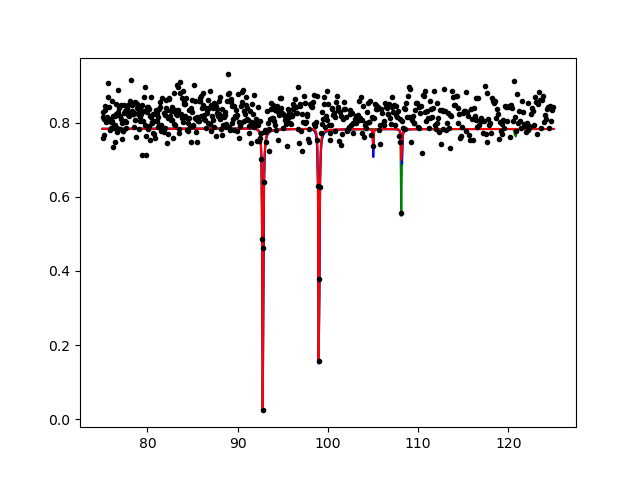

In [ ]:
# dc.theoretical_parameters['3_post'].resonance_ladder #.keys()

figure()
plot(dc.pw.exp.E, dc.pw.exp['true_trans'], 'g')
plot(dc.pw.exp.E, dc.pw.exp['5_prior_trans'], 'b')
plot(dc.pw.exp.E, dc.pw.exp['5_post_trans'], 'r')
plot(dc.pw.exp.E, dc.pw.exp.exp_trans, '.k')

In [ ]:
### Calculate Chi2 on trans
[ (chi2_val(dc.pw.exp[f'{numres}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT), numres) for numres in dc.theoretical_parameters.keys()]

[(642.6677276853724, 'true'),
 (34008.03804751533, '0_prior'),
 (30195.45631063132, '1_prior'),
 (809.0860109512934, '2_prior'),
 (761.3116362157965, '3_prior'),
 (755.6633892655166, '4_prior'),
 (732.4268334767725, '5_prior'),
 (731.2366152237604, '6_prior'),
 (730.2573056081044, '7_prior'),
 (728.8304510595933, '8_prior'),
 (727.7728481972074, '9_prior'),
 (726.8841701421162, '11_prior'),
 (726.1210785319432, '13_prior'),
 (725.5592926230319, '15_prior'),
 (725.4654040727328, '16_prior'),
 (680.8087001843618, '5_post')]

In [ ]:
### Interrogate

# print(dc.est_par['9_prior'].resonance_ladder[['E','Gt','Gnx','Gg','w']])
# # print(dc.est_par['10_prior'].resonance_ladder[['E','Gt','Gnx','Gg','w']])
# test, _,_ = SLBW(dc.pw.exp.E, Ta_pair, dc.est_par['9_prior'].resonance_ladder)

# rxn = 'xs'
# less = dc.pw.exp[f'9_prior_{rxn}']
# more = dc.pw.exp[f'10_prior_{rxn}']

# dat =dc.pw.exp[f'exp_{rxn}']
# figure()
# plot(dc.pw.exp.E, dc.pw.exp[f'theo_{rxn}'], 'g', lw=5)
# plot(dc.pw.exp.E, dat, '.k')
# plot(dc.pw.exp.E, less, 'b', lw=4)
# # plot(dc.pw.exp.E, more, 'r', lw=1)
# plot(dc.pw.exp.E, test, 'k', lw=1)

# # plot(dc.pw.exp.E, (less-dat)**2, 'b', lw=2)
# # plot(dc.pw.exp.E, (more-dat)**2, 'r', lw=1)

# print(chi2_val(less, dat, np.array(dc.pw.CovT)))
# # print(np.sum((less-dat)**2))
# print(chi2_val(more, dat, np.array(dc.pw.CovT)))
# # print(np.sum((more-dat)**2))

In [ ]:
### Interrogate some more

# numres = 5
# inumres = numres-min(target_numres)

# # constrained unreduced
# constrained_solution = target_sol_ws[:, inumres]

# fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
# inp3 = prob.get_MatrixInputs(dc, fb3)
# fb3.solution_ws = Solvers.solve_quadratic_program(inp3)

# prior = fb3.get_parameter_solution()
# prior = fill_resonance_ladder(prior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# sammyINP = sammy_classes.SammyInputData(
#     particle_pair = Ta_pair,
#     resonance_ladder = prior, 
#     experimental_data = dc.pw.exp, 
#     experimental_cov = dc.pw.CovT, 
# )

# lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
# posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# print(chi2_val(lst.theo_trans, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(chi2_val(lst.theo_trans_bayes, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(prior[['E','Gt','Gnx']])
# print(posterior[['E','Gt','Gnx']])

In [ ]:
### Run individual bayes


# numres = 7
# inumres = numres-min(target_numres)

# constrained_solution = target_sol_ws[:, inumres]

# fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
# inp3 = prob.get_MatrixInputs(dc, fb3)
# # fb3.solution_ws = cls.Solvers.solve_quadratic_program(inp3, qpopt)

# # prior = fb3.get_parameter_solution()
# # prior = fill_resonance_ladder(prior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# # est_par_builder = BuildTheoreticalParameters_fromATARI('test_prior', prior, Ta_pair)
# # est_par = est_par_builder.construct()
# # dc.add_theoretical_parameters(est_par)
  
# # sammyINP = sammy_classes.SammyInputData(
# #     particle_pair = Ta_pair,
# #     resonance_ladder = prior, 
# #     experimental_data = dc.pw.exp, 
# #     experimental_cov = dc.pw.CovT, 
# #     initial_parameter_uncertainty = 0.2
# # )


# print(f'Running recursive sammy for case {numres}')
# lst, posterior = run_recursive_sammy(sammyINP, sammyRTO, dc.pw.exp, dc.pw.CovT, Dchi2_threshold=0.1)


# posterior.rename(columns={'Gn1':'Gnx'}, inplace=True)
# posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)


# est_par_builder = BuildTheoreticalParameters_fromATARI('test_post', posterior, Ta_pair)
# est_par = est_par_builder.construct()
# dc.add_theoretical_parameters(est_par)

# dc.models_to_pw()

In [ ]:
# figure()
# plot(dc.pw.exp.E, dc.pw.exp.exp_xs, '.k')
# plot(dc.pw.exp.E, np.flipud(fb3.model))


In [ ]:

# print(chi2_val(dc.pw.exp['7_prior_trans'], dc.pw.exp.exp_trans, dc.pw.CovT))
# print(chi2_val(dc.pw.exp['7_post_trans'], dc.pw.exp.exp_trans, dc.pw.CovT))
# # print(prior[['E','Gt','Gnx']])
# # print(posterior[['E','Gt','Gnx']])

# figure()
# plot(dc.pw.exp.E, dc.pw.exp[f'true_trans'], 'g', lw=3)
# plot(dc.pw.exp.E, dc.pw.exp[f'exp_trans'], '.k')
# plot(dc.pw.exp.E, dc.pw.exp['7_prior_trans'], 'b', lw=1)
# plot(dc.pw.exp.E, dc.pw.exp['7_post_trans'], 'r', lw=1)

[print(key) for key in dc.theoretical_parameters.keys()]

true
0_prior
1_prior
2_prior
3_prior
4_prior
5_prior
6_prior
7_prior
8_prior
9_prior
11_prior
13_prior
15_prior
16_prior
5_post


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Step 5, Likelihood ratio test on each of the posterior solutions to determine which number of resonances we should have

In [ ]:
# [ (chi2_val(dc.pw.exp[f'{numres}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT), numres) for numres in dc.est_par.keys()]

posterior_ires_chi2 = [ (int(key.split('_')[0]),
                          chi2_val(dc.pw.exp[f'{key}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT))
                              for key in dc.theoretical_parameters.keys() if key!='true' and key!='final' and key.split('_')[1]=='post']
posterior_ires_chi2 = np.array(posterior_ires_chi2)
posterior_ires_chi2 = posterior_ires_chi2[posterior_ires_chi2[:, 0].argsort()]
posterior_ires_chi2

array([[  5.        , 680.80870018]])

In [ ]:
for key in dc.theoretical_parameters.keys():
    if key!='true' and key!='final' and key.split('_')[1]=='post':
        print(key)
        print(chi2_val(dc.pw.exp[f'{key}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT))

5_post
680.8087001843618


In [ ]:
import numpy as np
from scipy.stats import chi2

def likelihood_ratio_test(X2_null, X2_alt, df):
    """
    Perform a likelihood ratio test for nested models.

    Args:
        LLmin: Log-likelihood of the null (restricted) model.
        LLmax: Log-likelihood of the alternative (unrestricted) model.
        df: Degrees of freedom difference between the two models.

    Returns:
        lrt_stat: Likelihood ratio test statistic.
        p_value: p-value associated with the test statistic.
    """
    # lrt_stat = 2 * (LLalt - LLnull)
    lrt_stat = X2_null - X2_alt
    p_value = 1 - chi2.cdf(lrt_stat, df)
    return lrt_stat, p_value

def likelihood_val(fit):
    return sts.multivariate_normal.pdf( np.array(dc.pw.exp.exp_trans), fit, np.array(dc.pw.CovT) )
    

### Find first plausible model
for i in range(len(posterior_ires_chi2)):
    likelihood = likelihood_val( np.array(dc.pw.exp[f'{int(posterior_ires_chi2[i,0])}_post_trans']) )

    print(np.log(likelihood))
    if np.log(likelihood) >= -100:
        istart = i
        break
    elif i == len(posterior_ires_chi2)-1:
        istart = 0
        break




inull = istart 
ialt = inull
iend = np.shape(posterior_ires_chi2)[0]

significance_level = 0.05

while ialt < iend:

    # reset p_value
    p_value = 1.0

    while p_value > significance_level:

        ialt += 1
        if ialt == iend:
            break
        df_diff = posterior_ires_chi2[ialt][0]*3 - posterior_ires_chi2[inull][0]*3
        lrt_stat, p_value = likelihood_ratio_test(posterior_ires_chi2[inull][1], posterior_ires_chi2[ialt][1], df_diff)
        print(f"Model {posterior_ires_chi2[inull][0]} vs. Model {posterior_ires_chi2[ialt][0]}:\n p={p_value} D={lrt_stat}")
        # print(f"D: {lrt_stat}")
        # print(f"P-value: {p_value}")

    if ialt == iend:
        selected_model_ires = int(posterior_ires_chi2[inull][0])
        break
    else:
        inull = ialt

print(f'Model Selected: {posterior_ires_chi2[inull][0]}')

inf
Model Selected: 5.0


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/scipy/stats/_multivariate.py:583: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, mean, cov_object))


In [ ]:
# iresnull = 2
# iresalt = 5

# rxn = 'trans'
# null = dc.pw.exp[f'{iresnull}_post_{rxn}']
# alt = dc.pw.exp[f'{iresalt}_post_{rxn}']

# dat =dc.pw.exp[f'exp_{rxn}']
# figure()
# plot(dc.pw.exp.E, dc.pw.exp[f'true_{rxn}'], 'g', lw=3)
# plot(dc.pw.exp.E, dat, '.k')
# plot(dc.pw.exp.E, null, 'b', lw=1)
# plot(dc.pw.exp.E, alt, 'r', lw=1)


# print(chi2_val(null, dat, dc.pw.CovT))
# print(chi2_val(alt, dat, dc.pw.CovT))

# for each in dc.theoretical_parameters[f'{iresnull}_post'].resonance_ladder.E:
#     axvline(each, ymin=0.93,ymax=1, alpha=1, color='b', lw=3)

# for each in dc.theoretical_parameters[f'{iresalt}_post'].resonance_ladder.E:
#     axvline(each, ymin=0.93,ymax=1, alpha=1, color='r', lw=1)


In [ ]:
final_estimate = dc.theoretical_parameters[f'{selected_model_ires}_post'].resonance_ladder

# import time
# start_time = time.time()
# # final_estimate = main(args)
# end_time = time.time()
# elapsed_time = end_time - start_time
# final_estimate['tfit'] = np.ones(len(final_estimate))*elapsed_time
# final_estimate
# final_estimate.to_csv(f'./par_est_{casenum}.csv')


final_par = BuildTheoreticalParameters_fromATARI('final', final_estimate, Ta_pair)
dc.add_theoretical_parameters(final_par)
dc.mem_2_full()
dc.models_to_pw()

In [ ]:
# print(dc.theoretical_parameters[f'{selected_model_ires}_prior'].resonance_ladder)
# print(dc.theoretical_parameters[f'{selected_model_ires}_post'].resonance_ladder)

# print(dc.theoretical_parameters['true'].resonance_ladder)


Chi2 estimate to data: 680.8087001843618
Chi2 true to data: 642.6677276853724
Integral SE estimate to true: 44.366647826534866


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


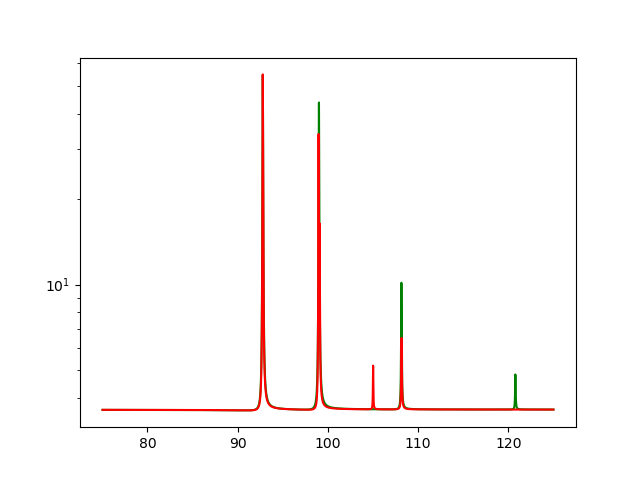

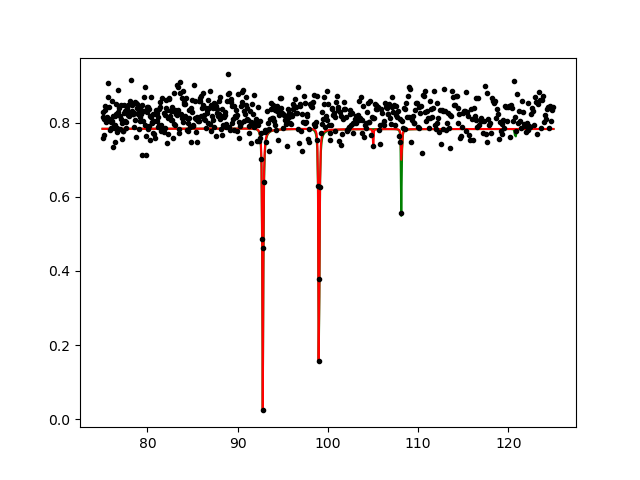

In [ ]:
est_chi_square = (dc.pw.exp.exp_trans-dc.pw.exp.final_trans) @ inv(dc.pw.CovT) @ (dc.pw.exp.exp_trans-dc.pw.exp.final_trans).T
sol_chi_square = (dc.pw.exp.exp_trans-dc.pw.exp.true_trans) @ inv(dc.pw.CovT) @ (dc.pw.exp.exp_trans-dc.pw.exp.true_trans).T
from scipy import integrate
est_sol_MSE = integrate.trapezoid((dc.pw.fine.true_xs-dc.pw.fine.final_xs)**2, dc.pw.fine.E)

print(f'Chi2 estimate to data: {est_chi_square}')
print(f'Chi2 true to data: {sol_chi_square}')
print(f'Integral SE estimate to true: {est_sol_MSE}')


figure()
plot(dc.pw.fine.E, dc.pw.fine.true_xs, 'g')
plot(dc.pw.fine.E, dc.pw.fine.final_xs, 'r')
yscale('log')
# ylim([0,dc.exp_par.max_xs+100])
figure()
plot(dc.pw.exp.E, dc.pw.exp.true_trans, 'g')
plot(dc.pw.exp.E, dc.pw.exp.final_trans, 'r')

# plot(dc.pw.exp.E, dc.pw.exp[f'{selected_model_ires}_post'], 'b')

plot(dc.pw.exp.E, dc.pw.exp.exp_trans, '.k')


## Notes

#### Initial uncertainty on parameters in sammy
should be large, we don't have a prior we just want the GLLS to converge.

Fudge factor cant be too larger for numerics:
 - M' = (M^-1 + (G.T @ V^-1 @ G.T) )^-1
 - first term is full rank, second is not guranteed (it is if NEpts>=NPar). Becasue the first term is full rank, then adding it to the second makes the whole thing full rank and therefore invertable. However, if the first term (M^-1 or 1/prior variance) is driven numerically to 0, then you are left with only the second term. If it is not full rank it won't be invertable then the thing will not be numerically stable. 

#### Sammy is not always converging
- could run sammy multiple times?
- also, the problem is resolved when I 'cheat' with the resonance energies. I think having multiple small resonances right on top of one another is causing sammy to run away.


#### Unexpected behavior when finding integer number of resonances
Often times the weight constrained solution for an integer number of resonances will have selected a smaller resonance than expected when there's a larger existing resonance that would drive the chi2 even lower. I believe this is a problem with not finding the maximum weight solution to an integer number of resonances.

- Now I am driving neutron width to the total leaving 0 Gt, currently hard coded max Gn = Gt-0.005

#### LRT
I am currently calculating the likelihood using sts.multivariate_normal.pdf. When trying to calculate it using just the chi2 to the data, I get an error because the determinate of the covariance matrix is 0... This seems incorrect.

Using LRT for nested models only works if the nested parameter are the exact same. I don't beleive that this is the case.

#### Other
- Can cutoff weights at 1e-5 or 6 because this corresponds directly to a neutron width this small of a resonance is insignificant